# Youtube Likes Prediction  
This notebook analys and predict the likes on youtube videos

In [ ]:
!pip install seaborn scikit-learn xgboost

## 0. import and download data

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import json

sns.set_theme(style="darkgrid")

## 0.1 Download the data

In [2]:
!kaggle datasets download datasnaek/youtube-new

'kaggle' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
! mkdir youtube-new
!tar -xf youtube-new.zip -C youtube-new

A subdirectory or file youtube-new already exists.
tar: Error opening archive: Failed to open 'youtube-new.zip'


# 1. EDA

In [102]:
df_raw = pd.read_csv("./youtube-new/USvideos.csv")

## 1.1 Review the data

In [103]:
df_raw.head().T

,0,1,2,3,4
video_id,2kyS6SvSYSE,1ZAPwfrtAFY,5qpjK5DgCt4,puqaWrEC7tY,d380meD0W0M
trending_date,17.14.11,17.14.11,17.14.11,17.14.11,17.14.11
title,WE WANT TO TALK ABOUT OUR MARRIAGE,The Trump Presidency: Last Week Tonight with J...,"Racist Superman | Rudy Mancuso, King Bach & Le...",Nickelback Lyrics: Real or Fake?,I Dare You: GOING BALD!?
channel_title,CaseyNeistat,LastWeekTonight,Rudy Mancuso,Good Mythical Morning,nigahiga
category_id,22,24,23,24,24
publish_time,2017-11-13T17:13:01.000Z,2017-11-13T07:30:00.000Z,2017-11-12T19:05:24.000Z,2017-11-13T11:00:04.000Z,2017-11-12T18:01:41.000Z
tags,SHANtell martin,"last week tonight trump presidency|""last week ...","racist superman|""rudy""|""mancuso""|""king""|""bach""...","rhett and link|""gmm""|""good mythical morning""|""...","ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""..."
views,748374,2418783,3191434,343168,2095731
likes,57527,97185,146033,10172,132235
dislikes,2966,6146,5339,666,1989


In [104]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                40949 non-null  object
 1   trending_date           40949 non-null  object
 2   title                   40949 non-null  object
 3   channel_title           40949 non-null  object
 4   category_id             40949 non-null  int64 
 5   publish_time            40949 non-null  object
 6   tags                    40949 non-null  object
 7   views                   40949 non-null  int64 
 8   likes                   40949 non-null  int64 
 9   dislikes                40949 non-null  int64 
 10  comment_count           40949 non-null  int64 
 11  thumbnail_link          40949 non-null  object
 12  comments_disabled       40949 non-null  bool  
 13  ratings_disabled        40949 non-null  bool  
 14  video_error_or_removed  40949 non-null  bool  
 15  de

First, let's verify that the `video_id` is unique for each row in the dataset.

In [206]:
df_raw.shape, df_raw.drop_duplicates(subset=["video_id"]).shape

((40949, 16), (6351, 16))

We see that the `video_id` is not unique for each row, so let's see how it is duplicated:

In [213]:
df_raw[df_raw["video_id"] == "eQVhAN7-IAw"].head(2).T

,216,427
video_id,eQVhAN7-IAw,eQVhAN7-IAw
trending_date,17.15.11,17.16.11
title,The Making of a Song: “Delicate” – watch more ...,The Making of a Song: “Delicate” – watch more ...
channel_title,Taylor Swift,Taylor Swift
category_id,10,10
publish_time,2017-11-15T03:43:47.000Z,2017-11-15T03:43:47.000Z
tags,"DIRECTV|""DIRECTVNOW""|""ATT""|""AT&T""|""The Making ...","DIRECTV|""DIRECTVNOW""|""ATT""|""AT&T""|""The Making ..."
views,125645,507753
likes,16754,35595
dislikes,65,483


We see that videos are duplicated because they have different trending dates. We will keep only the most first trending date for each video.

In [226]:
# Check if the trending date is sorted to avoid complications
assert (pd.to_datetime(
    df_raw["trending_date"], format="%y.%d.%m"
).sort_values().values != pd.to_datetime(
    df_raw["trending_date"], format="%y.%d.%m"
).values).sum() == 0

In [229]:
# drop duplicated video_ids and keep the first trending date
df_raw = df_raw.drop_duplicates(subset=["video_id"], keep="first")

In [230]:
df_raw.describe(percentiles=[0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 0.99]).applymap(
    lambda x: f"{x:0.3f}"
)

C:\Users\Gil Ben-David\AppData\Local\Temp\ipykernel_33992\2848146325.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_raw.describe(percentiles=[0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 0.99]).applymap(


,category_id,views,likes,dislikes,comment_count
count,6351.000,6351.000,6351.000,6351.000,6351.000
mean,20.444,758209.564,34493.570,1427.222,4501.707
std,7.213,1928993.100,116243.869,12078.815,21460.223
min,1.000,549.000,0.000,0.000,0.000
25%,17.000,83511.000,1908.000,72.000,261.000
50%,24.000,270902.000,7987.000,242.000,921.000
75%,25.000,751266.500,25163.000,763.000,2845.000
85%,26.000,1211205.500,48458.500,1422.000,5471.500
90%,27.000,1685423.000,73765.000,2224.000,8311.000
95%,28.000,2801378.500,132308.500,4136.000,15759.500


Let's look at the target variable: `likes`

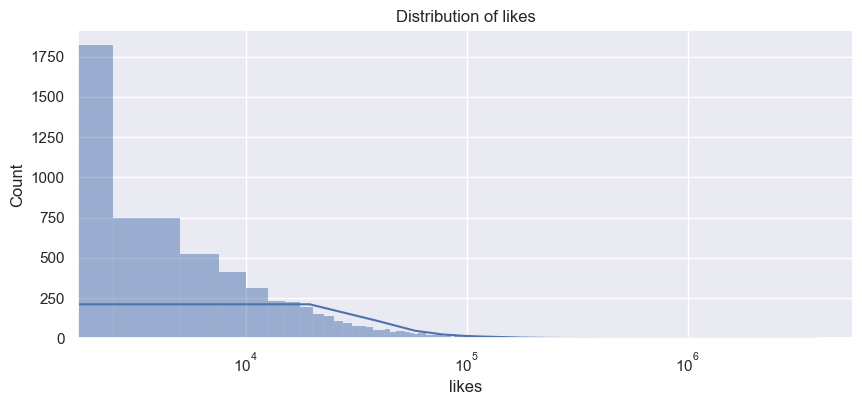

In [231]:
fig = plt.figure(figsize=(10, 4))
sns.histplot(df_raw["likes"], kde=True)
plt.xscale("log")

plt.title("Distribution of likes")
plt.show()

The tail is very long (we saw that in the `describe()` as well), let's cut the top 5% and see the histogram again

In [232]:
percentile_95_likes = df_raw["likes"].quantile(0.95)
df_filtered = df_raw[(df_raw["likes"] <= percentile_95_likes)]

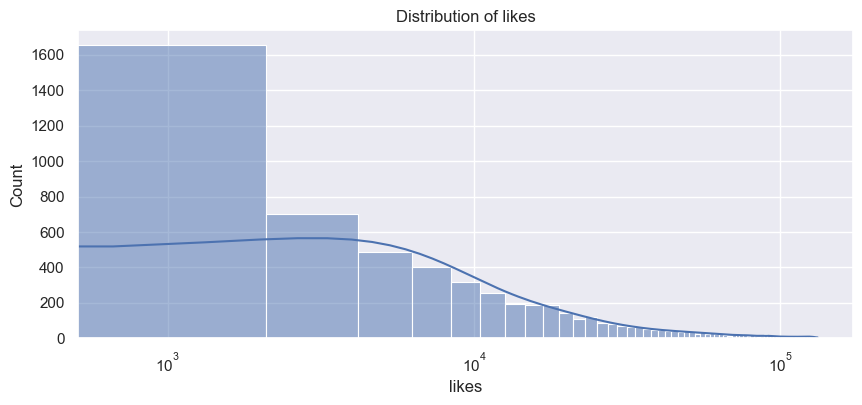

In [233]:
fig = plt.figure(figsize=(10, 4))
sns.histplot(df_filtered["likes"], kde=True)
plt.xscale("log")

plt.title("Distribution of likes")
plt.show()

## 1.2 Video Categories

In [312]:
df = df_filtered

Before we'll calculate the correlations between the numerical features and the target variable, we need to exclude the `category_id` feature, as it's a categorical feature.  
Let's load the categories names and merge them with the data

In [313]:
with open("youtube-new/US_category_id.json") as f:
    categories = json.load(f)

In [314]:
category_id_to_name = {int(category["id"]): category["snippet"]["title"] for category in categories["items"]}

In [315]:
df["category_name"] = df["category_id"].map(category_id_to_name)

C:\Users\Gil Ben-David\AppData\Local\Temp\ipykernel_33992\1543644931.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["category_name"] = df["category_id"].map(category_id_to_name)


In [316]:
df["category_name"].value_counts()

category_name
Entertainment            1569
Music                     667
Howto & Style             580
Comedy                    507
News & Politics           505
People & Blogs            473
Sports                    436
Science & Technology      376
Film & Animation          297
Education                 246
Pets & Animals            138
Gaming                     93
Autos & Vehicles           70
Travel & Events            60
Nonprofits & Activism      12
Shows                       4
Name: count, dtype: int64

We see that there are some categories with very few videos, let's aggregate them into a single category: `Other`

In [317]:
# Let's mark all the categories that have less than 500 videos as "Other"
categories_to_keep = df["category_name"].value_counts()[df["category_name"].value_counts() > 500].index
df.loc[~df["category_name"].isin(categories_to_keep), "category_name"] = "Other"

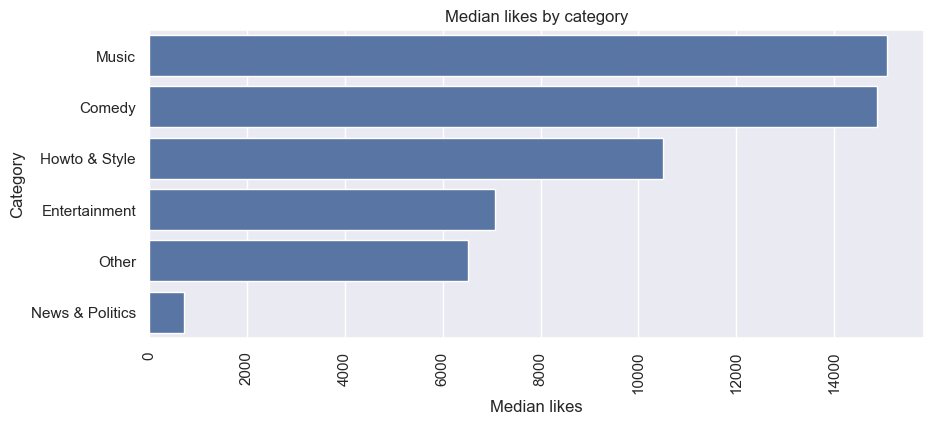

In [318]:
# Let's see the barplot of likes by category, sorted by the median
category_likes = df.groupby("category_name")["likes"].median().sort_values(ascending=False)
plt.figure(figsize=(10, 4))
sns.barplot(x=category_likes.values, y=category_likes.index)
plt.xlabel("Median likes")
plt.ylabel("Category")
plt.xticks(rotation=90)
plt.title("Median likes by category")
plt.show()

It seems like people like music and comedy videos the most, followed by Howto & Style.  
Let's remove the `category_id` feature and calculate the correlations

In [319]:
df = df.drop(columns=["category_id"])

## 1.3 Correlations

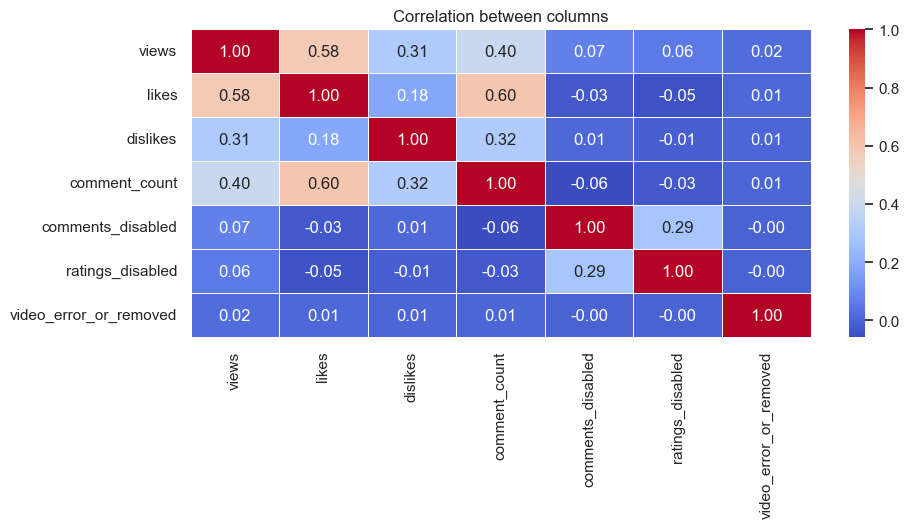

In [320]:
# See the correlation between the columns
plt.figure(figsize=(10, 4))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation between columns")
plt.show()

We can see from the heatmap that the `likes` are highly correlated with `views`, and `comment_count`. This is not surprising, as the more views a video has, the more likes and comments it will have.  
We can alse see that the `video_error_or_removed` feature has no correlation with the `likes` feature, so we'll take a deeper look at it

### 1.3.1 `video_error_or_removed` feature

In [321]:
df["video_error_or_removed"].value_counts()

video_error_or_removed
False    6030
True        3
Name: count, dtype: int64

In [322]:
df.groupby("video_error_or_removed")["likes"].mean()

video_error_or_removed
False    17266.206136
True     28608.333333
Name: likes, dtype: float64

There are only 3 videos with `video_error_or_removed` set to 1, with no significant difference in the `likes` feature.  
In order to avoid overfitting, we'll remove this feature from the data, and the rows with `video_error_or_removed` set to 1.

In [323]:
df = df[df["video_error_or_removed"] == False]
df = df.drop(columns=["video_error_or_removed"])

# 2. Feature Engineering

There are some features that we can create from the existing features, such as the `likes_per_view` and `likes_per_comment` features.  
Let's start with time manipulations features:

## 2.1 Time Features

We have 2 time features: `publish_time` and `trending_date`.  
Let's create the following features:
- `publish_hour`
- `publish_day`
- `publish_dayofweek`
- `publish_month`
- `publish_year`
- `trending_day`
- `trending_dayofweek`
- `trending_month`
- `trending_year`
- `days_to_trend`

### 2.1.1 Create the time features

In [324]:
df["publish_time"] = pd.to_datetime(df["publish_time"])
df["trending_date"] = pd.to_datetime(df["trending_date"], format="%y.%d.%m")

In [325]:
df[['publish_time', 'trending_date']].dtypes

publish_time     datetime64[ns, UTC]
trending_date         datetime64[ns]
dtype: object

In [326]:
dayofweek_mapping = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday",
}


def split_date(dt: pd.Timestamp):

    return {
        "year": dt.year,
        "month": dt.month,
        "day": dt.day,

        "dayofweek": dayofweek_mapping[dt.dayofweek],
        "hour": dt.hour,
    }



splitted_publish_time = df.apply(

    lambda x: split_date(x["publish_time"]), axis=1, result_type="expand"
)
splitted_trending_date = df.apply(

    lambda x: split_date(x["trending_date"]), axis=1, result_type="expand"
)


splitted_publish_time = splitted_publish_time.add_prefix("publish_time_")
splitted_trending_date = splitted_trending_date.add_prefix("trending_date_")


df = pd.concat([df, splitted_publish_time, splitted_trending_date], axis=1)

In [327]:
# And the days_to_trend column
df["days_to_trend"] = pd.to_timedelta(
    df["trending_date"].dt.date - df["publish_time"].dt.date
).dt.days

In [328]:
# We now that the trending_date_hour is always 0, so we can drop it
df = df.drop(columns=["trending_date_hour"])

### 2.1.2 publish hour

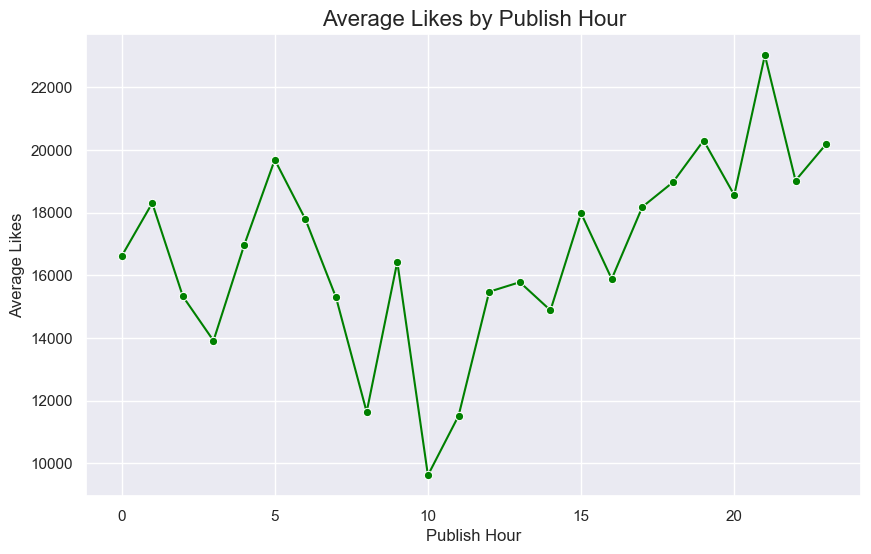

In [329]:
plt.figure(figsize=(10, 6))
publish_hour_likes = df.groupby("publish_time_hour")["likes"].mean()
sns.lineplot(
    x=publish_hour_likes.index,
    y=publish_hour_likes.values,
    marker="o",
    color="green",
)
plt.title("Average Likes by Publish Hour", fontsize=16)
plt.xlabel("Publish Hour", fontsize=12)
plt.ylabel("Average Likes", fontsize=12)
plt.show()

It seems like the videos that were published on the late noon (around 5-9 PM) have the most likes.

### 2.1.3 day of week

In [330]:
# Convert the days of the week to a categorical type
df["publish_time_dayofweek"] = pd.Categorical(
    df["publish_time_dayofweek"],
    categories=list(dayofweek_mapping.values()),
    ordered=True,
)

df["trending_date_dayofweek"] = pd.Categorical(
    df["trending_date_dayofweek"],
    categories=list(dayofweek_mapping.values()),
    ordered=True,
)

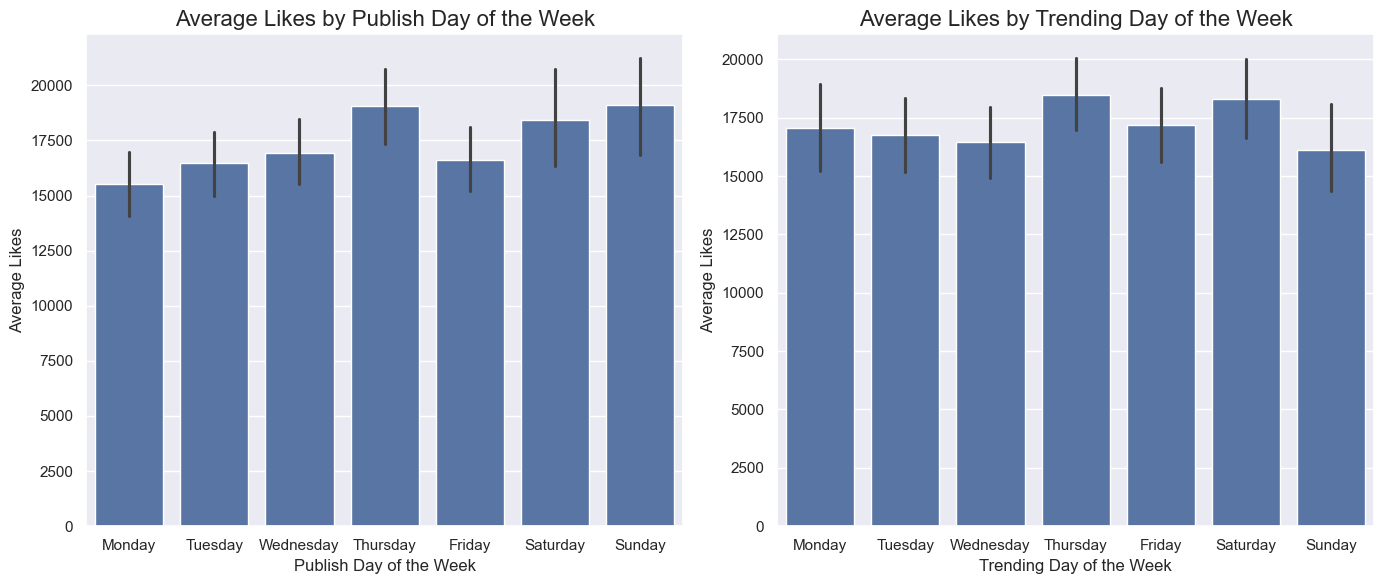

In [331]:
# Let's see the distribution of likes by day of the week for both publish and trending date using barplots in the same figure
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(
    x="publish_time_dayofweek",
    y="likes",
    data=df,
    estimator=np.mean,
    ax=ax[0],
)
ax[0].set_title("Average Likes by Publish Day of the Week", fontsize=16)
ax[0].set_xlabel("Publish Day of the Week", fontsize=12)
ax[0].set_ylabel("Average Likes", fontsize=12)

sns.barplot(
    x="trending_date_dayofweek",
    y="likes",
    data=df,
    estimator=np.mean,
    ax=ax[1],
)
ax[1].set_title("Average Likes by Trending Day of the Week", fontsize=16)
ax[1].set_xlabel("Trending Day of the Week", fontsize=12)
ax[1].set_ylabel("Average Likes", fontsize=12)
plt.tight_layout()
plt.show()

We can see that the `trending_dayofweek` feature has no significant correlation with the `likes` feature, so we'll remove it.  
In contrast, the `publish_dayofweek` feature has a correlation with the `likes` feature, so we'll keep it.  

We see that videos that were published on Sunday have the most likes, followed by Thursday and Friday.

In [332]:
df = df.drop(columns=["trending_date_dayofweek"])

### 2.1.4 month

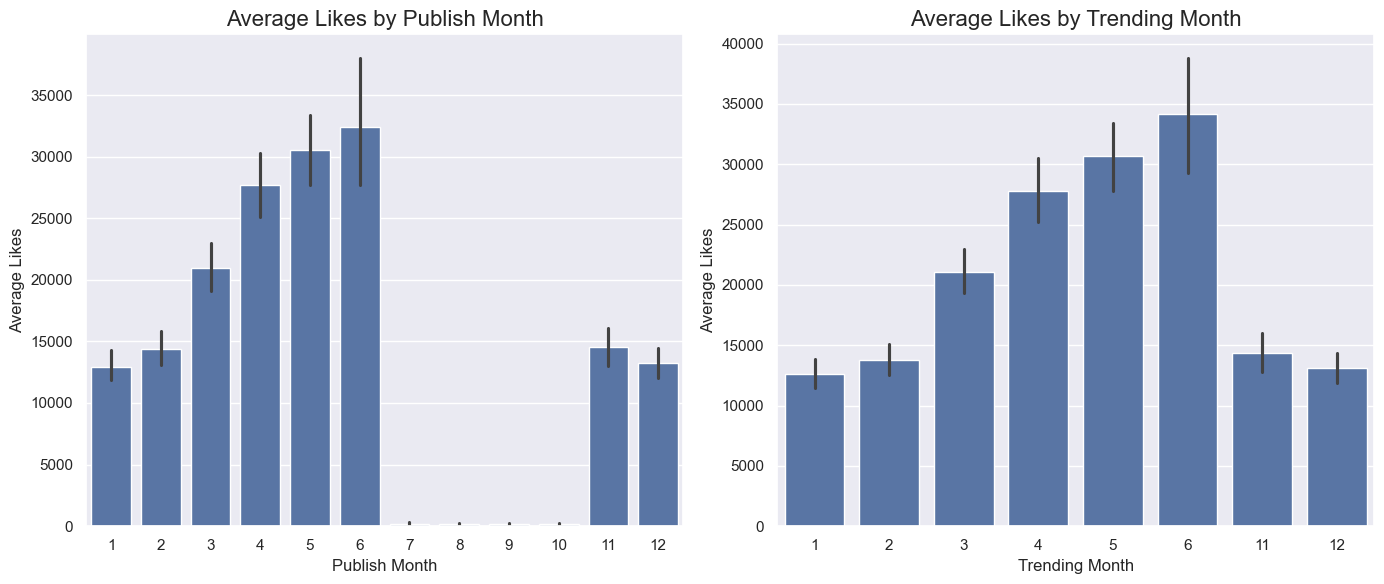

In [333]:
# Now let's see the distribution of likes by month for both publish and trending date using barplots in the same figure
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(
    x="publish_time_month",
    y="likes",
    data=df,
    estimator=np.mean,
    ax=ax[0],
)
ax[0].set_title("Average Likes by Publish Month", fontsize=16)
ax[0].set_xlabel("Publish Month", fontsize=12)
ax[0].set_ylabel("Average Likes", fontsize=12)

sns.barplot(
    x="trending_date_month",
    y="likes",
    data=df,
    estimator=np.mean,
    ax=ax[1],
)
ax[1].set_title("Average Likes by Trending Month", fontsize=16)
ax[1].set_xlabel("Trending Month", fontsize=12)
ax[1].set_ylabel("Average Likes", fontsize=12)
plt.tight_layout()
plt.show()

The graphs look a bit weird, where there are no videos published/trending on months 7-10 (July-October).  
Let's check the data for these months

In [334]:
df["publish_time_month"].value_counts(), df["trending_date_month"].value_counts()

(publish_time_month
 1     1228
 12    1113
 2      965
 11     941
 3      650
 4      491
 5      478
 6      127
 10      17
 9       10
 8        6
 7        4
 Name: count, dtype: int64,
 trending_date_month
 1     1195
 12    1163
 2     1029
 11     874
 3      655
 4      488
 5      485
 6      141
 Name: count, dtype: int64)

It seems like there are no videos from these months, let's check that we didn't drop them by mistake in the trimming process

In [335]:
pd.to_datetime(df_raw["publish_time"]).dt.month.value_counts(), pd.to_datetime(
    df_raw["trending_date"], format="%y.%d.%m"
).dt.month.value_counts()

(publish_time
 1     1269
 12    1166
 2      995
 11     972
 3      688
 5      540
 4      537
 6      147
 10      17
 9       10
 8        6
 7        4
 Name: count, dtype: int64,
 trending_date
 1     1238
 12    1215
 2     1059
 11     904
 3      692
 5      543
 4      534
 6      166
 Name: count, dtype: int64)

We see that there are no videos from these months, so we'll remove the `publish_month` and `trending_month` features, to avoid overfitting.

In [336]:
df = df.drop(columns=["trending_date_month", "publish_time_month"])

### 2.1.5 day

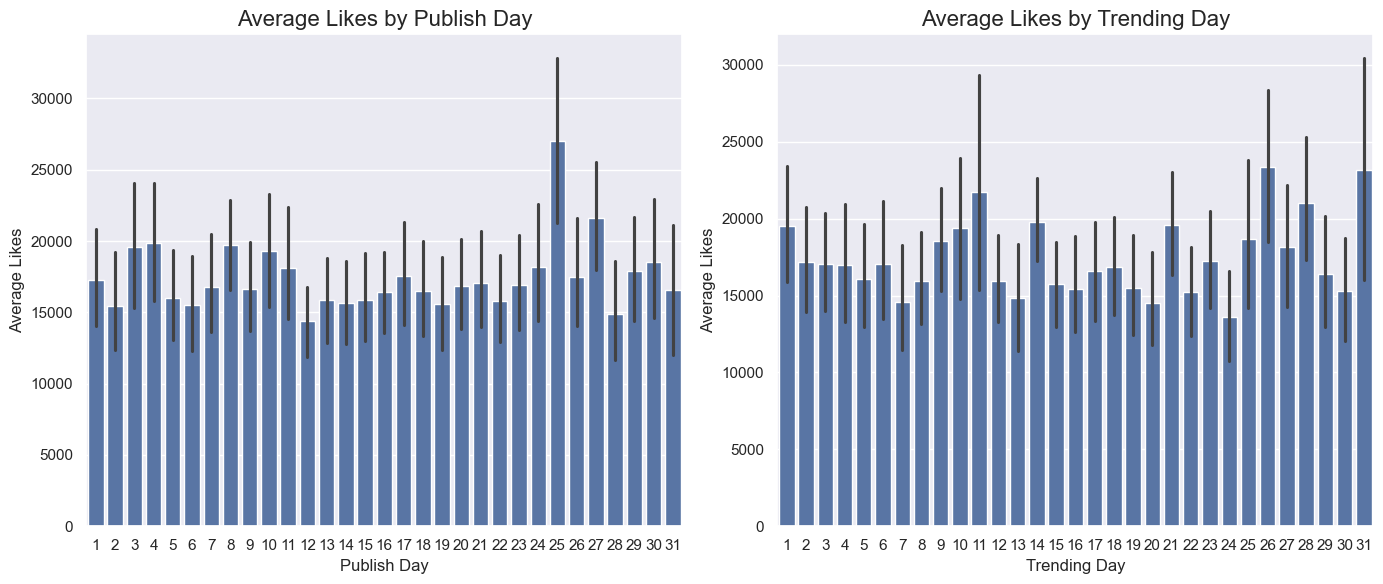

In [337]:
# Let's see the distribution of likes by day for both publish and trending date using barplots in the same figure
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(
    x="publish_time_day",
    y="likes",
    data=df,
    estimator=np.mean,
    ax=ax[0],
)
ax[0].set_title("Average Likes by Publish Day", fontsize=16)
ax[0].set_xlabel("Publish Day", fontsize=12)
ax[0].set_ylabel("Average Likes", fontsize=12)

sns.barplot(
    x="trending_date_day",
    y="likes",
    data=df,
    estimator=np.mean,
    ax=ax[1],
)
ax[1].set_title("Average Likes by Trending Day", fontsize=16)
ax[1].set_xlabel("Trending Day", fontsize=12)
ax[1].set_ylabel("Average Likes", fontsize=12)
plt.tight_layout()
plt.show()

We can see that the `publish_day` and `trending_day` features have some effect on the `likes` feature, even though it's not very significant.  
We'll keep these features for now.

### 2.1.6 year

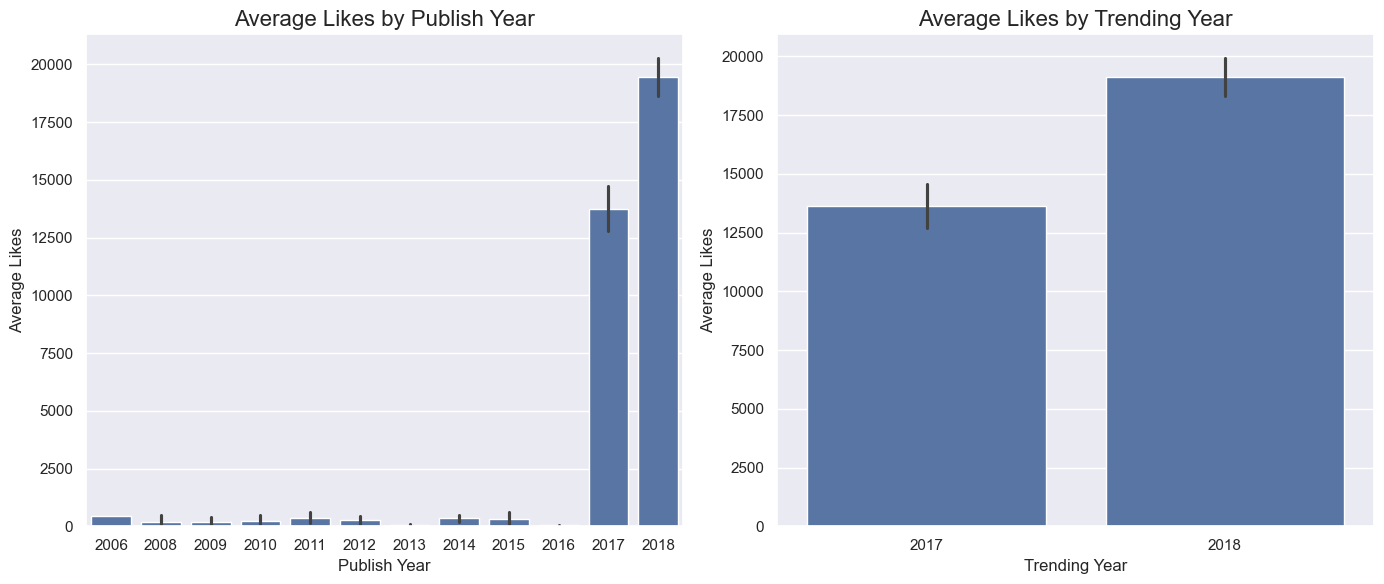

In [338]:
# Let's see the distribution of likes by year for both publish and trending date using barplots in the same figure
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(
    x="publish_time_year",
    y="likes",
    data=df,
    estimator=np.mean,
    ax=ax[0],
)
ax[0].set_title("Average Likes by Publish Year", fontsize=16)
ax[0].set_xlabel("Publish Year", fontsize=12)
ax[0].set_ylabel("Average Likes", fontsize=12)

sns.barplot(
    x="trending_date_year",
    y="likes",
    data=df,
    estimator=np.mean,
    ax=ax[1],
)
ax[1].set_title("Average Likes by Trending Year", fontsize=16)
ax[1].set_xlabel("Trending Year", fontsize=12)
ax[1].set_ylabel("Average Likes", fontsize=12)
plt.tight_layout()
plt.show()

The `publish_year` and `trending_year` features are not scattered enough, so we'll remove them as well.

In [339]:
df = df.drop(columns=["trending_date_year", "publish_time_year"])

### 2.1.5 days_to_trend

In [340]:
df["days_to_trend"].describe(percentiles=[0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 0.98, 0.99, 0.9999])

count     6030.000000
mean        23.609619
std        215.425418
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
85%          4.000000
90%          5.000000
95%          6.000000
98%         17.000000
99%        727.630000
99.99%    3821.909200
max       4215.000000
Name: days_to_trend, dtype: float64

It seems like there are some anomalies in the `days_to_trend` feature, let's trim the data and see the histogram again

In [350]:
days_to_trend_percentile_95 = df["days_to_trend"].quantile(0.95)
df = df[df["days_to_trend"] <= days_to_trend_percentile_95]

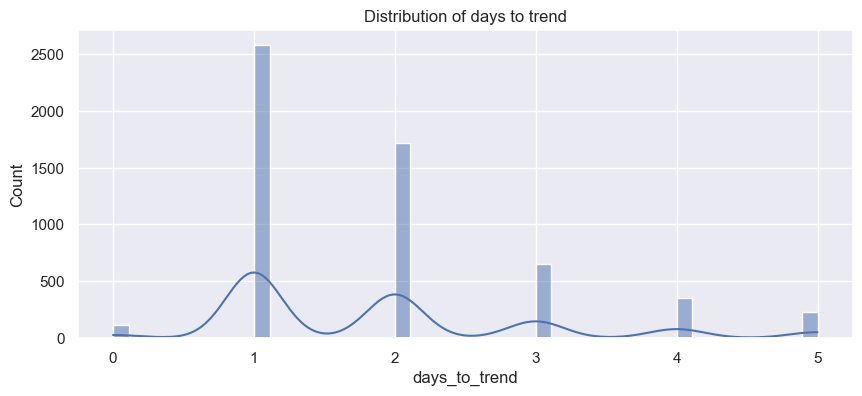

In [351]:
# Let's see the distribution of likes by days_to_trend using a histogram
plt.figure(figsize=(10, 4))
sns.histplot(df["days_to_trend"], kde=True)
plt.title("Distribution of days to trend")
plt.show()

In [352]:
# Let's see the correlation between the days_to_trend and the likes
correlation_days_to_trend_likes = df["days_to_trend"].corr(df["likes"])
print(f"Correlation between days_to_trend and likes: {correlation_days_to_trend_likes:.2f}")

Correlation between days_to_trend and likes: -0.07


We see that the `days_to_trend` feature has a no effect on the `likes` feature, but we'll keep it.  
Now all left to do is to remove the `publish_time` and `trending_date` features.

In [344]:
df = df.drop(columns=["publish_time", "trending_date"])

## 2.2 Textual features

We have 3 textual features: `title` and `tags`, and `description`.  
We can create the following features:
- `title_length`
- `title_words_count`
- `tags_count`
- `description_length`
- `description_words_count`

In [345]:
df["title_length"] = df["title"].apply(lambda x: len(x))
df["title_words"] = df["title"].apply(lambda x: len(x.split()))
df["tags_count"] = df["tags"].apply(lambda x: len(x.split("|")))

# Not all videos have a description, so we need to check for that
df["description_length"] = df["description"].apply(lambda x: len(x) if isinstance(x, str) else 0)
df["description_words"] = df["description"].apply(
    lambda x: len(x.split()) if isinstance(x, str) else 0
)

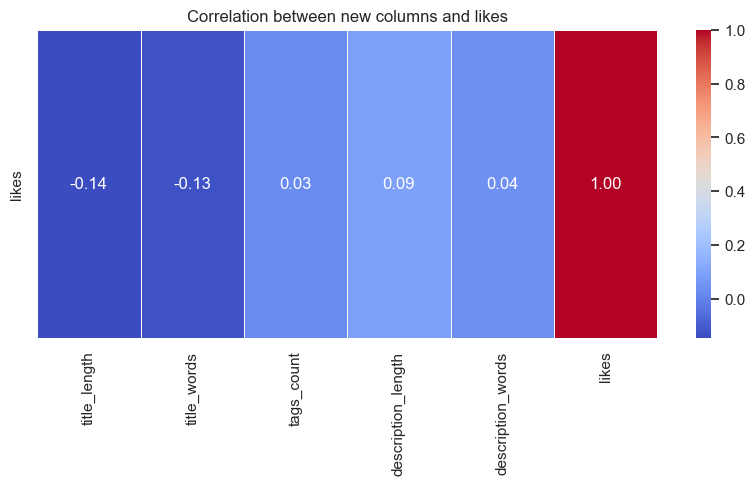

In [346]:
# Let's see the correlation between the new columns and the likes
plt.figure(figsize=(10, 4))
corr_df = df[["title_length", "title_words", "tags_count", "description_length", "description_words", "likes"]].corr().loc[["likes"]]
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation between new columns and likes")
plt.show()

We see that these features have no effect on the `likes` feature, so we'll drop them.

In [347]:
df = df.drop(columns=["title_length", "title_words", "tags_count", "description_length", "description_words"])

And now we can remove the `title`, `tags`, and `description` features.

In [348]:
df = df.drop(columns=["title", "tags", "description"])

# 3. Model

In this part, we'll build a model to predict the `likes` feature.

## 3.1 Train-Test Split

In [349]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5912 entries, 0 to 40766
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   video_id                5912 non-null   object  
 1   channel_title           5912 non-null   object  
 2   views                   5912 non-null   int64   
 3   likes                   5912 non-null   int64   
 4   dislikes                5912 non-null   int64   
 5   comment_count           5912 non-null   int64   
 6   thumbnail_link          5912 non-null   object  
 7   comments_disabled       5912 non-null   bool    
 8   ratings_disabled        5912 non-null   bool    
 9   category_name           5912 non-null   object  
 10  publish_time_day        5912 non-null   int64   
 11  publish_time_dayofweek  5912 non-null   category
 12  publish_time_hour       5912 non-null   int64   
 13  trending_date_day       5912 non-null   int64   
 14  days_to_trend           5912